In [4]:
import os
import glob
import shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from huggingface_hub import snapshot_download
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from lightgbm import LGBMRegressor

/Users/mikolajzakrzewski/GitHub/11-Best-Hacking-League-AI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [209]:
import os
import glob
import pandas as pd
from huggingface_hub import snapshot_download

# 1. Download dataset repo
local_dir = snapshot_download(
    repo_id="ejhusom/llm-inference-energy-consumption",
    repo_type="dataset",
)

# 2. Point to folder with CSVs
data_dir = os.path.join(local_dir, "data")

# 3. Read and label each CSV
dfs = []
for path in glob.glob(os.path.join(data_dir, "*.csv")):
    fname = os.path.basename(path)
    print("Reading:", fname)

    # infer label: laptop or workstation
    if "laptop1" in fname.lower():
        device_type = "laptop1"
    if "laptop2" in fname.lower():
        device_type = "laptop2"
    elif "workstation" in fname.lower():
        device_type = "workstation"
    elif "server" in fname.lower():
        device_type = "server"
    else:
        device_type = "unknown"

    df = pd.read_csv(path)
    df["device_type"] = device_type   # add as a new column
    dfs.append(df)

# 4. Merge all CSVs
full_df = pd.concat(dfs, ignore_index=True)

# 5. Save merged version
full_df.to_parquet("llm_inference_energy.parquet", index=False)
full_df.to_csv("llm_inference_energy.csv", index=False)

print("✅ Combined shape:", full_df.shape)
print("✅ Unique device types:", full_df["device_type"].unique())


Fetching 17 files: 100%|██████████| 17/17 [00:00<00:00, 92842.67it/s]


Reading: codefeedback_gemma_7b_workstation.csv
Reading: codefeedback_gemma_7b_laptop2.csv
Reading: codefeedback_codellama_70b_workstation.csv
Reading: alpaca_llama3_8b_laptop2.csv
Reading: alpaca_gemma_7b_workstation.csv
Reading: alpaca_gemma_2b_workstation.csv
Reading: alpaca_gemma_7b_laptop2.csv
Reading: codefeedback_gemma_2b_workstation.csv
Reading: alpaca_llama3_70b_server.csv
Reading: codefeedback_codellama_7b_laptop1.csv
Reading: alpaca_gemma_2b_laptop1.csv
Reading: codefeedback_codellama_7b_laptop2.csv
Reading: alpaca_gemma_2b_laptop2.csv
Reading: codefeedback_codellama_7b_workstation.csv
Reading: codefeedback_gemma_2b_laptop2.csv
✅ Combined shape: (78728, 81)
✅ Unique device types: ['workstation' 'laptop2' 'server' 'unknown']


In [67]:
full_df.columns

Index(['Unnamed: 0', 'index', 'model_name', 'created_at', 'total_duration',
       'load_duration', 'prompt_token_length', 'prompt_duration',
       'response_token_length', 'response_duration', 'prompt', 'response',
       'energy_consumption_monitoring', 'energy_consumption_llm_cpu',
       'energy_consumption_llm_gpu', 'type', 'clock_duration', 'start_time',
       'end_time', 'energy_consumption_llm_total', 'energy_consumption_llm',
       'word_count', 'sentence_count', 'avg_word_length', 'word_diversity',
       'unique_word_count', 'avg_sentence_length', 'punctuation_count',
       'stop_word_count', 'long_word_count', 'named_entity_count',
       'noun_count', 'verb_count', 'adj_count', 'adverb_count',
       'pronoun_count', 'prop_adverbs', 'prop_pronouns', 'sentiment_polarity',
       'sentiment_subjectivity', 'flesch_reading_ease', 'flesch_kincaid_grade',
       'gunning_fog', 'smog_index', 'automated_readability_index',
       'coleman_liau_index', 'linsear_write_formula',


In [5]:
full_df = pd.read_csv("llm_inference_energy.csv")

## Data Cleaning

### Attach device hardware info

In [25]:
device_specs = {
    "server": {
        "cpu_vendor": "AMD",
        "cpu_family": "EPYC 7643",
        "cpu_cores": 48,
        "cpu_base_clock_ghz": np.nan,  # unknown from your string; fill later if needed
        "ram_gb": 528,
        "has_gpu": 1,
        "gpu_model": "RTX A5000",
        "gpu_vram_gb": 24,
        "gpu_class": "pro",
        "device_family": "server",
        "is_mobile": 0,
    },
    "workstation": {
        "cpu_vendor": "Intel",
        "cpu_family": "Xeon W-2223",
        "cpu_cores": 8,
        "cpu_base_clock_ghz": 3.6,
        "ram_gb": 128,
        "has_gpu": 1,
        "gpu_model": "RTX A2000",
        "gpu_vram_gb": 12,
        "gpu_class": "pro",
        "device_family": "workstation",
        "is_mobile": 0,
    },
    "laptop1": {
        "cpu_vendor": "Intel",
        "cpu_family": "Core i5 11th Gen",
        "cpu_cores": 12,
        "cpu_base_clock_ghz": 2.4,
        "ram_gb": 16,
        "has_gpu": 0,
        "gpu_model": "None",
        "gpu_vram_gb": 0,
        "gpu_class": "none",
        "device_family": "laptop",
        "is_mobile": 1,
    },
    "laptop2": {
        "cpu_vendor": "Intel",
        "cpu_family": "Core i7 10th Gen",
        "cpu_cores": 12,
        "cpu_base_clock_ghz": 2.7,
        "ram_gb": 32,
        "has_gpu": 1,
        "gpu_model": "Quadro RTX 4000",
        "gpu_vram_gb": 8,
        "gpu_class": "pro",
        "device_family": "laptop",
        "is_mobile": 1,
    },
}

device_df = pd.DataFrame.from_dict(device_specs, orient="index")
device_df.index.name = "device_type"
device_df.reset_index(inplace=True)

full_df = full_df.merge(device_df, on="device_type", how="left")

full_df.head()

,Unnamed: 0,index,model_name,created_at,total_duration,load_duration,prompt_token_length,prompt_duration,response_token_length,response_duration,...,cpu_family,cpu_cores,cpu_base_clock_ghz,ram_gb,has_gpu,gpu_model,gpu_vram_gb,gpu_class,device_family,is_mobile
0,0,0,gemma:7b,2024-06-03 02:13:29.004344899+00:00,1.741032e+10,6.968346e+09,37.0,134927000.0,379.0,1.017014e+10,...,Xeon W-2223,8.0,3.6,128.0,1.0,RTX A2000,12.0,pro,workstation,0.0
1,1,0,gemma:7b,2024-06-03 02:13:41.902790699+00:00,9.671784e+09,1.541572e+06,37.0,181520000.0,352.0,9.353939e+09,...,Xeon W-2223,8.0,3.6,128.0,1.0,RTX A2000,12.0,pro,workstation,0.0
2,2,0,gemma:7b,2024-06-03 02:13:57.400980604+00:00,1.237931e+10,1.630014e+06,33.0,182270000.0,454.0,1.206248e+10,...,Xeon W-2223,8.0,3.6,128.0,1.0,RTX A2000,12.0,pro,workstation,0.0
3,3,0,gemma:7b,2024-06-03 02:14:06.652099238+00:00,6.128086e+09,1.746157e+06,80.0,251387000.0,220.0,5.737241e+09,...,Xeon W-2223,8.0,3.6,128.0,1.0,RTX A2000,12.0,pro,workstation,0.0
4,4,0,gemma:7b,2024-06-03 02:14:20.845969425+00:00,1.110313e+10,1.693462e+06,34.0,172202000.0,410.0,1.079840e+10,...,Xeon W-2223,8.0,3.6,128.0,1.0,RTX A2000,12.0,pro,workstation,0.0


In [6]:
full_df.dtypes

Unnamed: 0                     int64
index                          int64
model_name                    object
created_at                    object
total_duration               float64
                              ...   
avg_sentence_length_cubed    float64
lexical_diversity            float64
device_type                   object
Unnamed: 0.1                 float64
Unnamed: 0.2                 float64
Length: 81, dtype: object

In [26]:
full_df_cleaned = full_df.copy()

### Convert categorical columns to 'category' dtype

In [27]:
cat_cols = ['model_name', 'text_standard', 'device_type']

for col in cat_cols:
    full_df_cleaned[col] = full_df_cleaned[col].astype('category')

### Renaming Models for Integrity

### Feature Categorization and Selection

In [28]:
rename_map = {
    "codellama": "codellama:7b",
    "llama3": "llama3:8b",
}

full_df_cleaned['model_name'] = full_df_cleaned['model_name'].replace(rename_map)

/var/folders/pg/r0xzmlhx55v1_4mt6mj6_plr0000gn/T/ipykernel_72343/1101231600.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  full_df_cleaned['model_name'] = full_df_cleaned['model_name'].replace(rename_map)


In [76]:
param_map = {
    "gemma:2b":       2e9,
    "gemma:7b":       7e9,
    "codellama:7b":   7e9,
    "llama3:8b":      8e9,
    "llama3:70b":     70e9,
    "codellama:70b":  70e9,
}

full_df_cleaned["model_params"] = full_df_cleaned["model_name"].map(param_map).astype(float)  # number of parameters
full_df_cleaned["model_params_billion"] = full_df_cleaned["model_params"] / 1e9               # in billions
full_df_cleaned["log_model_params"] = np.log1p(full_df_cleaned["model_params"])               # for modeling


In [77]:
# === 1. Metadata / junk columns ===
metadata_cols = [
    "Unnamed: 0",
    "Unnamed: 0.1",
    "Unnamed: 0.2",
    "index",
    "created_at",
    "type",
]

# === 2. Equipment / setup (known before inference) ===
equipment_cols = [
    "model_name",
    "model_params",
    "model_params_billion",
    "log_model_params",
    "device_type",
]

hardware_feature_cols = [
    "cpu_cores", "cpu_base_clock_ghz", "ram_gb",
    "has_gpu", "gpu_vram_gb", "is_mobile"
]

# === 3. Prompt-related columns ===

# raw prompt text
prompt_text_cols = [
    "prompt",
]

# prompt-level stats / features (length, POS, readability, etc.)
prompt_stat_cols = [
    # size / length / structure
    "prompt_token_length",
    "word_count",
    "sentence_count",
    "avg_word_length",
    "word_diversity",
    "unique_word_count",
    "avg_sentence_length",
    "punctuation_count",
    "stop_word_count",
    "long_word_count",
    "syllable_count",
    "lexicon_count",
    "char_count",
    "letter_count",
    "polysyllabcount",
    "monosyllabcount",
    "question_marks",
    "exclamation_marks",
    "word_count_squared",
    "avg_sentence_length_cubed",
    "sentence_embedding_variance",
    "length_x_complexity",
    "desc_complexity_ratio",
    "lexical_diversity",

    # POS / entities
    "named_entity_count",
    "noun_count",
    "verb_count",
    "adj_count",
    "adverb_count",
    "pronoun_count",
    "prop_adverbs",
    "prop_pronouns",
    "personal_pronouns",
    "named_entities",
    "adjectives",
    "adverbs",
    "questions_about_entities",

    # sentiment + readability / complexity
    "sentiment_polarity",
    "sentiment_subjectivity",
    "flesch_reading_ease",
    "flesch_kincaid_grade",
    "gunning_fog",
    "smog_index",
    "automated_readability_index",
    "coleman_liau_index",
    "linsear_write_formula",
    "dale_chall_readability_score",
    "text_standard",
    "spache_readability",
    "mcalpine_eflaw",
    "reading_time",
    "fernandez_huerta",
    "szigriszt_pazos",
    "gutierrez_polini",
    "crawford",
    "osman",
    "gulpease_index",
    "wiener_sachtextformel",
]

# if you want a single list of usable prompt-side predictors:
prompt_feature_cols = equipment_cols + hardware_feature_cols + prompt_stat_cols


In [79]:
# === 4. Response-related columns (DO NOT use as predictors) ===

# raw response text
response_text_cols = [
    "response",
]

# response size & timing
response_stat_cols = [
    "response_token_length",
    "response_duration",
]

# === 5. Runtime / timing (post-hoc, not prompt-side) ===
runtime_cols = [
    "total_duration",
    "load_duration",
    "prompt_duration",
    "clock_duration",
    "start_time",
    "end_time",
]

# === 6. Energy measurements (targets) ===
energy_cols = [
    "energy_consumption_monitoring",
    "energy_consumption_llm_cpu",
    "energy_consumption_llm_gpu",
    "energy_consumption_llm_total",
    "energy_consumption_llm",
]

# === 7. Convenience: columns to DROP for a prompt→energy model ===
drop_for_model_cols = (
    metadata_cols
    + prompt_text_cols
    + response_text_cols
    + response_stat_cols
    + runtime_cols
    + energy_cols
)

# final feature set example: prompt features only (what you actually want)
X_feature_cols = prompt_feature_cols  # use this for X = df[X_feature_cols]
y_col = "energy_consumption_llm_total"  # or whichever energy metric you pick


In [80]:
rename_map = {
    "codellama": "codellama:7b",
    "llama3": "llama3:8b",
}

full_df_cleaned['model_name'] = full_df_cleaned['model_name'].replace(rename_map)

In [81]:
full_df_cleaned['model_name'].value_counts(normalize=True)

model_name
gemma:2b         0.405167
gemma:7b         0.294266
codellama:7b     0.220697
llama3:8b        0.064793
llama3:70b       0.013032
codellama:70b    0.002045
Name: proportion, dtype: float64

In [187]:
valid_models = [
    # "gemma:2b",
    "gemma:7b",
    # "codellama:7b",
]

In [83]:
full_df_cleaned[['model_name', 'device_type']].value_counts(normalize=True)

model_name     device_type
gemma:2b       workstation    0.276763
gemma:7b       workstation    0.186249
codellama:7b   unknown        0.135835
gemma:2b       laptop2        0.128404
gemma:7b       laptop2        0.108017
llama3:8b      laptop2        0.064793
codellama:7b   laptop2        0.045371
               workstation    0.039490
llama3:70b     server         0.013032
codellama:70b  workstation    0.002045
Name: proportion, dtype: float64

In [84]:
full_df.columns

Index(['Unnamed: 0', 'index', 'model_name', 'created_at', 'total_duration',
       'load_duration', 'prompt_token_length', 'prompt_duration',
       'response_token_length', 'response_duration', 'prompt', 'response',
       'energy_consumption_monitoring', 'energy_consumption_llm_cpu',
       'energy_consumption_llm_gpu', 'type', 'clock_duration', 'start_time',
       'end_time', 'energy_consumption_llm_total', 'energy_consumption_llm',
       'word_count', 'sentence_count', 'avg_word_length', 'word_diversity',
       'unique_word_count', 'avg_sentence_length', 'punctuation_count',
       'stop_word_count', 'long_word_count', 'named_entity_count',
       'noun_count', 'verb_count', 'adj_count', 'adverb_count',
       'pronoun_count', 'prop_adverbs', 'prop_pronouns', 'sentiment_polarity',
       'sentiment_subjectivity', 'flesch_reading_ease', 'flesch_kincaid_grade',
       'gunning_fog', 'smog_index', 'automated_readability_index',
       'coleman_liau_index', 'linsear_write_formula',


In [85]:
prompt_stat_cols

['prompt_token_length',
 'word_count',
 'sentence_count',
 'avg_word_length',
 'word_diversity',
 'unique_word_count',
 'avg_sentence_length',
 'punctuation_count',
 'stop_word_count',
 'long_word_count',
 'syllable_count',
 'lexicon_count',
 'char_count',
 'letter_count',
 'polysyllabcount',
 'monosyllabcount',
 'question_marks',
 'exclamation_marks',
 'word_count_squared',
 'avg_sentence_length_cubed',
 'sentence_embedding_variance',
 'length_x_complexity',
 'desc_complexity_ratio',
 'lexical_diversity',
 'named_entity_count',
 'noun_count',
 'verb_count',
 'adj_count',
 'adverb_count',
 'pronoun_count',
 'prop_adverbs',
 'prop_pronouns',
 'personal_pronouns',
 'named_entities',
 'adjectives',
 'adverbs',
 'questions_about_entities',
 'sentiment_polarity',
 'sentiment_subjectivity',
 'flesch_reading_ease',
 'flesch_kincaid_grade',
 'gunning_fog',
 'smog_index',
 'automated_readability_index',
 'coleman_liau_index',
 'linsear_write_formula',
 'dale_chall_readability_score',
 'text_sta

In [86]:
equipment_cols

['model_name',
 'model_params',
 'model_params_billion',
 'log_model_params',
 'device_type']

In [38]:
response_stat_cols

['response_token_length', 'response_duration']

In [75]:
equipment_cols

['model_name',
 'model_params',
 'model_params_billion',
 'log_model_params',
 'device_type']

In [115]:
equipment_cols

['model_name',
 'model_params',
 'model_params_billion',
 'log_model_params',
 'device_type']

In [117]:
# --- config ---
from sklearn.metrics import mean_absolute_percentage_error
target_col = "energy_consumption_llm"   # pick your target
feature_cols = (
    prompt_stat_cols
    +
    equipment_cols
    +
    hardware_feature_cols
    # +
    # response_stat_cols
)

# --- prepare data ---
df_model = (
    full_df_cleaned[feature_cols + [target_col]]
    .copy()
    # .query("model_name in @valid_models")
    .query("device_type != 'server'")
    .query("model_params <= 8e9")   # up to 8B params
)

X = df_model[feature_cols]
y = df_model[target_col]

# --- simple train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42,
)

# --- LGBMRegressor ---
model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

model.fit(X_train, y_train)

# --- predictions ---
y_pred = model.predict(X_test)

# --- metrics ---
mae = mean_absolute_error(y_test, y_pred)

# MAPE with zero-division guard
eps = 1e-12
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # in percentage

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# adjusted R²
n = len(y_test)
p = X_test.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"MAE:         {mae:.8f}")
print(f"MAPE:        {mape:.4f}%")
print(f"RMSE:        {rmse:.8f}")
print(f"R²:          {r2:.6f}")
print(f"Adjusted R²: {adj_r2:.6f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11154
[LightGBM] [Info] Number of data points in the train set: 65196, number of used features: 69
[LightGBM] [Info] Start training from score 0.000114
MAE:         0.00007745
MAPE:        98.8420%
RMSE:        0.00168931
R²:          0.002328
Adjusted R²: -0.007268


In [167]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from lightgbm import LGBMRegressor

# --- sMAPE helper ---
def smape(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_pred - y_true)
    return np.mean(diff / np.clip(denom, eps, None)) * 100.0  # %

# --- config ---
target_col = "prompt_duration"  # or your output-length col
feature_cols = (
    prompt_stat_cols
    + equipment_cols
    + hardware_feature_cols
    # + response_stat_cols
)

# --- prepare data ---
df_model = (
    full_df_cleaned[feature_cols + [target_col]]
    .copy()
    # .query("device_type != 'server'")
    # .query("model_params <= 8e9")   # up to 8B params
).dropna(subset=[target_col])

X = df_model[feature_cols]
y_raw = df_model[target_col].to_numpy().astype(float)

# log1p target for training
y_log = np.log1p(y_raw)

# --- 10-fold CV setup ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
mape_scores = []
smape_scores = []
rmse_scores = []
r2_scores = []
adj_r2_scores = []

# >>> NEW: accumulators for global totals <<<
total_abs_error = 0.0          # sum |y_true - y_pred|
total_target_sum = 0.0         # sum y_true (original scale)
total_n = 0                    # total number of samples across folds

for fold, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train_log = y_log[train_idx]
    y_test_raw = y_raw[test_idx]  # keep original scale for metrics

    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )

    # train on log target
    model.fit(X_train, y_train_log)

    # predict in log space, then back-transform
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    # --- metrics per fold (on original scale) ---
    mae = mean_absolute_error(y_test_raw, y_pred)
    mape = mean_absolute_percentage_error(y_test_raw, y_pred) * 100  # %
    s_mape = smape(y_test_raw, y_pred)  # symmetric MAPE
    rmse = root_mean_squared_error(y_test_raw, y_pred)
    r2 = r2_score(y_test_raw, y_pred)

    n_fold = len(y_test_raw)
    p = X_train.shape[1]
    adj_r2 = 1 - (1 - r2) * (n_fold - 1) / (n_fold - p - 1)

    mae_scores.append(mae)
    mape_scores.append(mape)
    smape_scores.append(s_mape)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)

    # >>> NEW: accumulate global totals <<<
    total_abs_error += np.sum(np.abs(y_test_raw - y_pred))
    total_target_sum += np.sum(y_test_raw)
    total_n += n_fold

    print(
        f"Fold {fold:02d} | "
        f"MAE={mae:.6f}, MAPE={mape:.3f}%, sMAPE={s_mape:.3f}%, "
        f"RMSE={rmse:.6f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}"
    )

# --- averaged metrics ---
def mean_std(arr):
    return np.mean(arr), np.std(arr)

mae_mean, mae_std = mean_std(mae_scores)
mape_mean, mape_std = mean_std(mape_scores)
smape_mean, smape_std = mean_std(smape_scores)
rmse_mean, rmse_std = mean_std(rmse_scores)
r2_mean, r2_std = mean_std(r2_scores)
adj_r2_mean, adj_r2_std = mean_std(adj_r2_scores)

print("\n=== 10-fold CV results (mean ± std) ===")
print(f"MAE:           {mae_mean:.8f} ± {mae_std:.8f}")
print(f"MAPE:          {mape_mean:.4f}% ± {mape_std:.4f}%")
print(f"sMAPE:         {smape_mean:.4f}% ± {smape_std:.4f}%")
print(f"RMSE:          {rmse_mean:.8f} ± {rmse_std:.8f}")
print(f"R²:            {r2_mean:.6f} ± {r2_std:.6f}")
print(f"Adjusted R²:   {adj_r2_mean:.6f} ± {adj_r2_std:.6f}")

# --- NEW: global total error vs total target sum ---
overall_mae = total_abs_error / total_n  # should be very close to mae_mean
rel_total_error = (total_abs_error / total_target_sum) * 100.0  # %

print("\n=== Global totals across all folds ===")
print(f"Total abs error:      {total_abs_error:.6f}")
print(f"Total target sum:     {total_target_sum:.6f}")
print(f"Overall MAE:          {overall_mae:.6f}")
print(f"Total error / target: {rel_total_error:.4f}%")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11139
[LightGBM] [Info] Number of data points in the train set: 62952, number of used features: 69
[LightGBM] [Info] Start training from score 20.135317
Fold 01 | MAE=242796765.258374, MAPE=8.058%, sMAPE=7.251%, RMSE=1853752533.187549, R²=0.9487, Adj R²=0.9485
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11171
[LightGBM] [Info] Number of data points in the train set: 62952, number of used features: 69
[LightGBM] [Info] Start training from score 20.135764
Fold 02 | MAE=212372546.481291, MAPE=8.800%, sMAPE=7.481%, RMSE=1139368159.1

In [165]:
full_df_cleaned

,Unnamed: 0,index,model_name,created_at,total_duration,load_duration,prompt_token_length,prompt_duration,response_token_length,response_duration,...,ram_gb,has_gpu,gpu_model,gpu_vram_gb,gpu_class,device_family,is_mobile,model_params,model_params_billion,log_model_params
0,0,0,gemma:7b,2024-06-03 02:13:29.004344899+00:00,1.741032e+10,6.968346e+09,37.0,134927000.0,379.0,1.017014e+10,...,128.0,1.0,RTX A2000,12.0,pro,workstation,0.0,7.000000e+09,7.0,22.669176
1,1,0,gemma:7b,2024-06-03 02:13:41.902790699+00:00,9.671784e+09,1.541572e+06,37.0,181520000.0,352.0,9.353939e+09,...,128.0,1.0,RTX A2000,12.0,pro,workstation,0.0,7.000000e+09,7.0,22.669176
2,2,0,gemma:7b,2024-06-03 02:13:57.400980604+00:00,1.237931e+10,1.630014e+06,33.0,182270000.0,454.0,1.206248e+10,...,128.0,1.0,RTX A2000,12.0,pro,workstation,0.0,7.000000e+09,7.0,22.669176
3,3,0,gemma:7b,2024-06-03 02:14:06.652099238+00:00,6.128086e+09,1.746157e+06,80.0,251387000.0,220.0,5.737241e+09,...,128.0,1.0,RTX A2000,12.0,pro,workstation,0.0,7.000000e+09,7.0,22.669176
4,4,0,gemma:7b,2024-06-03 02:14:20.845969425+00:00,1.110313e+10,1.693462e+06,34.0,172202000.0,410.0,1.079840e+10,...,128.0,1.0,RTX A2000,12.0,pro,workstation,0.0,7.000000e+09,7.0,22.669176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78723,5003,0,gemma:2b,2024-06-01 02:56:21.710485879+00:00,1.270741e+09,7.547870e+05,35.0,116970000.0,122.0,1.151378e+09,...,32.0,1.0,Quadro RTX 4000,8.0,pro,laptop,1.0,2.000000e+09,2.0,21.416413
78724,5004,0,gemma:2b,2024-06-01 02:56:30.215538783+00:00,2.404869e+09,9.610790e+05,12.0,113981000.0,245.0,2.288177e+09,...,32.0,1.0,Quadro RTX 4000,8.0,pro,laptop,1.0,2.000000e+09,2.0,21.416413
78725,5005,0,gemma:2b,2024-06-01 02:56:37.274653516+00:00,3.901594e+09,1.083439e+06,111.0,140465000.0,411.0,3.756338e+09,...,32.0,1.0,Quadro RTX 4000,8.0,pro,laptop,1.0,2.000000e+09,2.0,21.416413
78726,5006,0,gemma:2b,2024-06-01 02:56:46.342859083+00:00,2.954175e+09,7.562270e+05,31.0,111209000.0,311.0,2.840123e+09,...,32.0,1.0,Quadro RTX 4000,8.0,pro,laptop,1.0,2.000000e+09,2.0,21.416413


In [178]:
hardware_feature_cols

['cpu_cores',
 'cpu_base_clock_ghz',
 'ram_gb',
 'has_gpu',
 'gpu_vram_gb',
 'is_mobile']

In [189]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from lightgbm import LGBMRegressor

# --- sMAPE helper ---
def smape(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_pred - y_true)
    return np.mean(diff / np.clip(denom, eps, None)) * 100.0  # %

# --- config ---
len_target_col = "prompt_duration"      # change if your name differs
energy_target_col = "energy_consumption_llm_total"  # change if your name differs

feature_cols = (
    # prompt_stat_cols
    equipment_cols
    + hardware_feature_cols
    # + response_stat_cols   # keep commented if you don't want response-side leakage
)

# --- prepare data ---
df_model = (
    full_df_cleaned[feature_cols + [len_target_col, energy_target_col]]
    .copy()
    .query("model_name in @valid_models")
    .query("device_type != 'server'")
    .query("model_params <= 8e9")   # e.g. up to 8B params
    .dropna(subset=[len_target_col, energy_target_col])
)

X_base = df_model[feature_cols]
y_len_raw = df_model[len_target_col].to_numpy().astype(float)
y_energy_raw = df_model[energy_target_col].to_numpy().astype(float)

# log1p targets for training
y_len_log = np.log1p(y_len_raw)
y_energy_log = np.log1p(y_energy_raw)

# --- 5-fold CV setup ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
mape_scores = []
smape_scores = []
rmse_scores = []
r2_scores = []
adj_r2_scores = []

# global totals for energy
total_abs_error = 0.0          # sum |y_true - y_pred|
total_target_sum = 0.0         # sum y_true
total_n = 0

for fold, (train_idx, test_idx) in enumerate(kf.split(X_base), start=1):
    # base features
    X_train_base, X_test_base = X_base.iloc[train_idx], X_base.iloc[test_idx]

    # targets split
    y_len_train_log = y_len_log[train_idx]
    y_len_test_raw = y_len_raw[test_idx]

    y_energy_train_log = y_energy_log[train_idx]
    y_energy_test_raw = y_energy_raw[test_idx]

    # --- Stage 1: predict response length (stacked feature) ---
    len_model = LGBMRegressor(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )

    len_model.fit(X_train_base, y_len_train_log)

    # predicted length (back to original scale)
    y_len_pred_train_log = len_model.predict(X_train_base)
    y_len_pred_test_log = len_model.predict(X_test_base)

    y_len_pred_train = np.expm1(y_len_pred_train_log)
    y_len_pred_test = np.expm1(y_len_pred_test_log)

    # optional: check how well length model does on test
    # (not strictly needed for the energy model, but useful to inspect)
    # len_mae = mean_absolute_error(y_len_test_raw, y_len_pred_test)
    # print(f"Fold {fold:02d} | Length MAE={len_mae:.2f}")

    # --- Build extended features with predicted length ---
    X_train = X_train_base.copy()
    X_test = X_test_base.copy()

    X_train["pred_response_token_length"] = y_len_pred_train
    X_test["pred_response_token_length"] = y_len_pred_test

    # --- Stage 2: predict energy using original features + predicted length ---
    energy_model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )

    energy_model.fit(X_train, y_energy_train_log)

    # predict in log space then back-transform
    y_energy_pred_log = energy_model.predict(X_test)
    y_energy_pred = np.expm1(y_energy_pred_log)

    # --- metrics per fold (on original energy scale) ---
    mae = mean_absolute_error(y_energy_test_raw, y_energy_pred)
    mape = mean_absolute_percentage_error(y_energy_test_raw, y_energy_pred) * 100  # %
    s_mape = smape(y_energy_test_raw, y_energy_pred)
    rmse = root_mean_squared_error(y_energy_test_raw, y_energy_pred)
    r2 = r2_score(y_energy_test_raw, y_energy_pred)

    n_fold = len(y_energy_test_raw)
    p = X_train.shape[1]
    adj_r2 = 1 - (1 - r2) * (n_fold - 1) / (n_fold - p - 1)

    mae_scores.append(mae)
    mape_scores.append(mape)
    smape_scores.append(s_mape)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)

    # accumulate global totals for energy
    total_abs_error += np.sum(np.abs(y_energy_test_raw - y_energy_pred))
    total_target_sum += np.sum(y_energy_test_raw)
    total_n += n_fold

    print(
        f"Fold {fold:02d} | "
        f"MAE={mae:.6f}, MAPE={mape:.3f}%, sMAPE={s_mape:.3f}%, "
        f"RMSE={rmse:.6f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}"
    )

# --- averaged metrics (energy) ---
def mean_std(arr):
    return np.mean(arr), np.std(arr)

mae_mean, mae_std = mean_std(mae_scores)
mape_mean, mape_std = mean_std(mape_scores)
smape_mean, smape_std = mean_std(smape_scores)
rmse_mean, rmse_std = mean_std(rmse_scores)
r2_mean, r2_std = mean_std(r2_scores)
adj_r2_mean, adj_r2_std = mean_std(adj_r2_scores)

print("\n=== 5-fold CV results for ENERGY (mean ± std) ===")
print(f"MAE:           {mae_mean:.8f} ± {mae_std:.8f}")
print(f"MAPE:          {mape_mean:.4f}% ± {mape_std:.4f}%")
print(f"sMAPE:         {smape_mean:.4f}% ± {smape_std:.4f}%")
print(f"RMSE:          {rmse_mean:.8f} ± {rmse_std:.8f}")
print(f"R²:            {r2_mean:.6f} ± {r2_std:.6f}")
print(f"Adjusted R²:   {adj_r2_mean:.6f} ± {adj_r2_std:.6f}")

# --- Global total error vs total target sum (energy) ---
overall_mae = total_abs_error / total_n
rel_total_error = (total_abs_error / total_target_sum) * 100.0  # %

print("\n=== Global totals across all folds (ENERGY) ===")
print(f"Total abs error:      {total_abs_error:.6f}")
print(f"Total target sum:     {total_target_sum:.6f}")
print(f"Overall MAE:          {overall_mae:.6f}")
print(f"Total error / target: {rel_total_error:.4f}%")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 18532, number of used features: 6
[LightGBM] [Info] Start training from score 20.425127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [158]:
# TreeExplainer works well for LightGBM
explainer = shap.TreeExplainer(model)

# use a sample of training data for speed
if len(X_train) > 1000:
    X_shap = X_train.sample(n=1000, random_state=42)
else:
    X_shap = X_train

# for classic (older) shap versions: this returns a numpy array
shap_values = explainer.shap_values(X_shap)


[LightGBM] [Fatal] The number of features in data (70) is not the same as it was in training data (69).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (70) is not the same as it was in training data (69).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [159]:
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="dot",   # beeswarm
    max_display=20     # top 20 features
)


ValueError: The shape of the shap_values matrix does not match the shape of the provided data matrix. Perhaps the extra column in the shap_values matrix is the constant offset? Of so just pass shap_values[:,:-1].

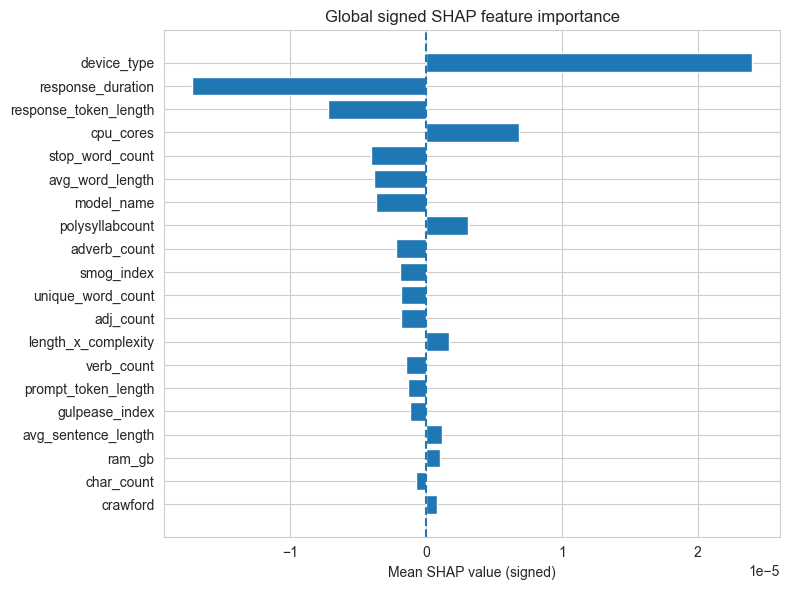

In [125]:
import numpy as np
import matplotlib.pyplot as plt

# shap_values: (n_samples, n_features) for regression
# X_shap: DataFrame with same columns as used in shap_values
feature_names = np.array(X_shap.columns)

# mean signed effect per feature
mean_shap = shap_values.mean(axis=0)  # keep sign

# sort by absolute effect, descending
idx_sorted = np.argsort(-np.abs(mean_shap))
idx_sorted = idx_sorted[:20]  # top 20 features

mean_shap_sorted = mean_shap[idx_sorted]
feature_names_sorted = feature_names[idx_sorted]

plt.figure(figsize=(8, 6))
plt.barh(range(len(idx_sorted)), mean_shap_sorted)
plt.yticks(range(len(idx_sorted)), feature_names_sorted)
plt.axvline(0, linestyle="--")
plt.gca().invert_yaxis()  # largest at top
plt.xlabel("Mean SHAP value (signed)")
plt.title("Global signed SHAP feature importance")
plt.tight_layout()
plt.show()


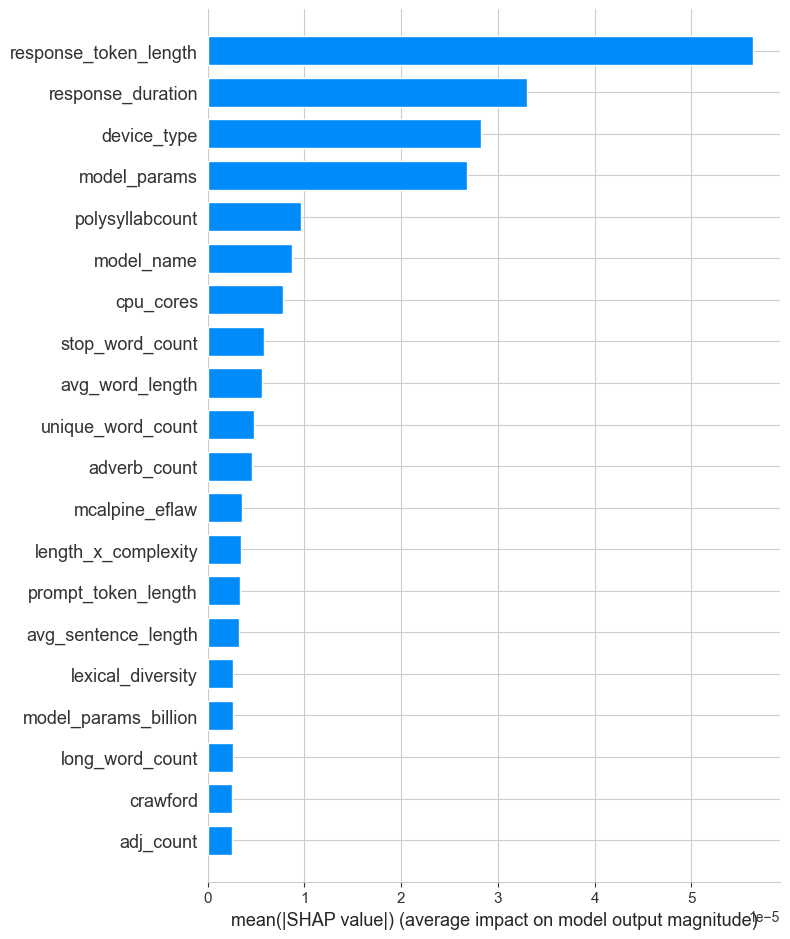

In [126]:
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",
    max_display=20,      # top N features
)


Main feature for interactions: response_token_length
Interaction: response_token_length × model_params_billion


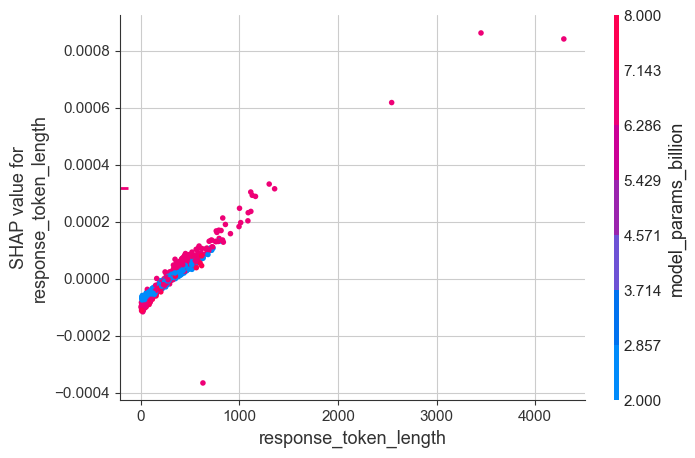

Interaction: response_token_length × model_params


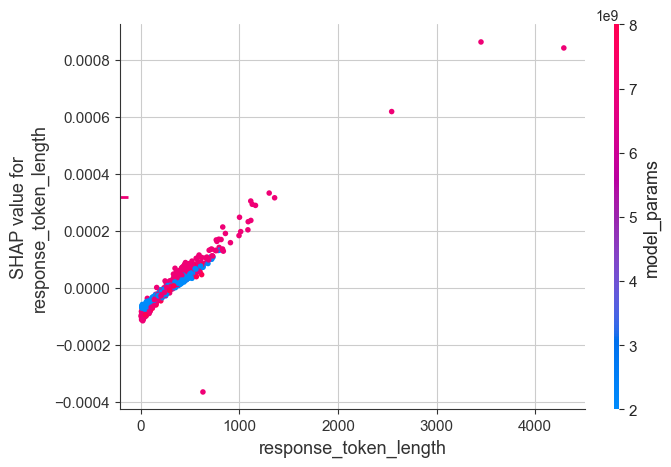

Interaction: response_token_length × log_model_params


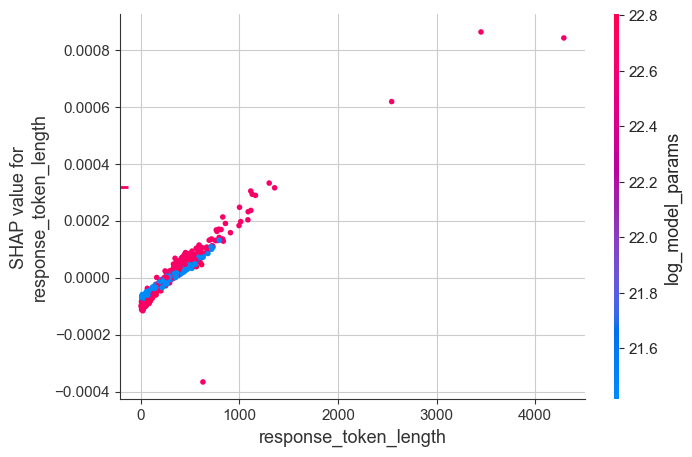

Interaction: response_token_length × model_name


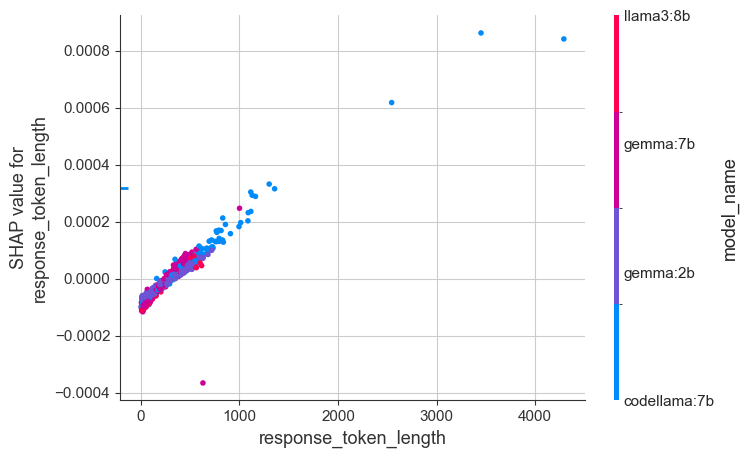

Interaction: response_token_length × device_type


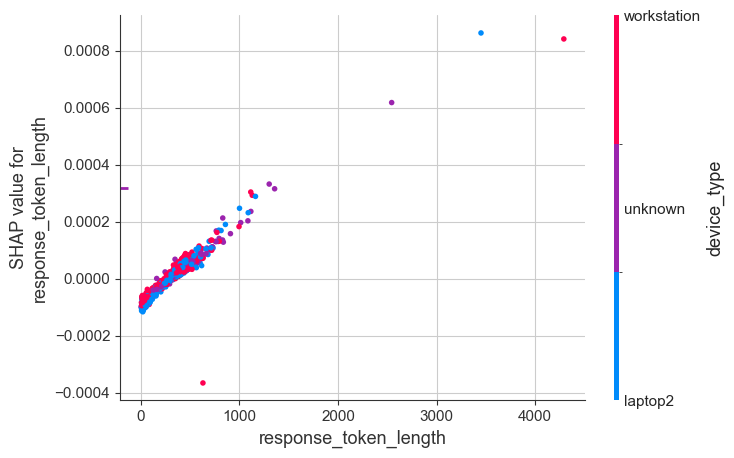

Interaction: response_token_length × response_duration


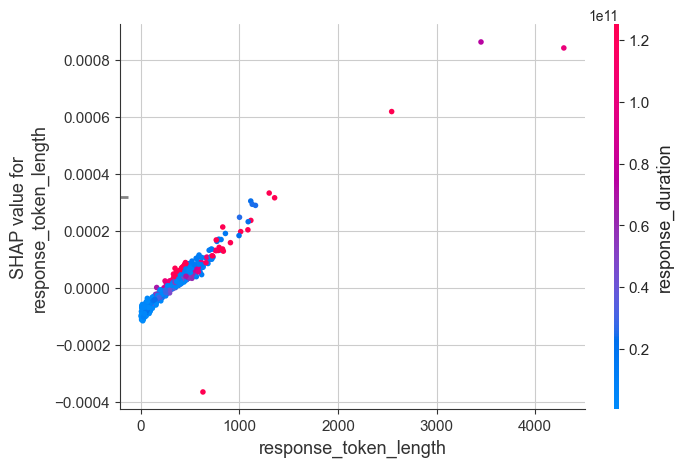

Interaction: response_token_length × adverb_count


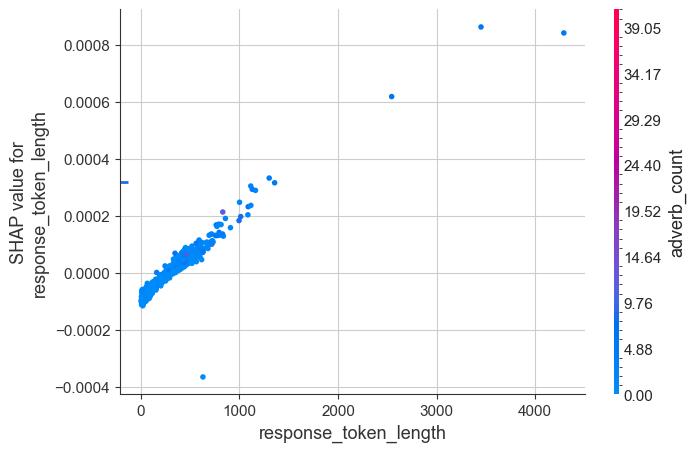

Interaction: response_token_length × adverbs


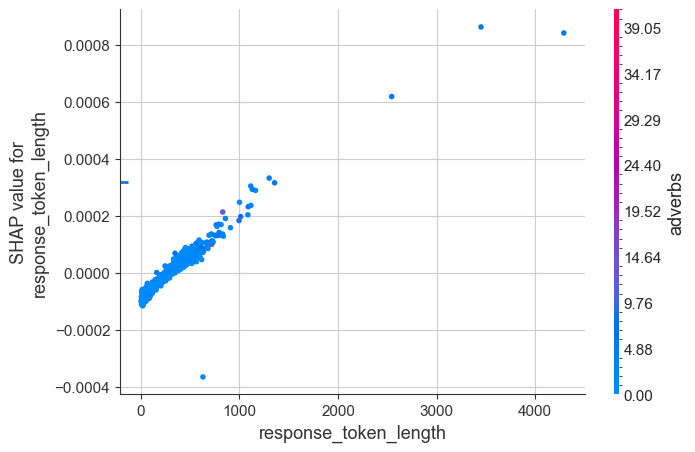

Interaction: response_token_length × avg_sentence_length


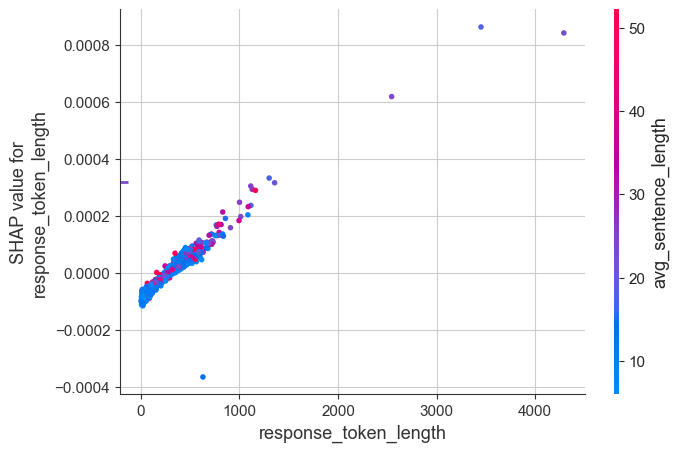

Interaction: response_token_length × mcalpine_eflaw


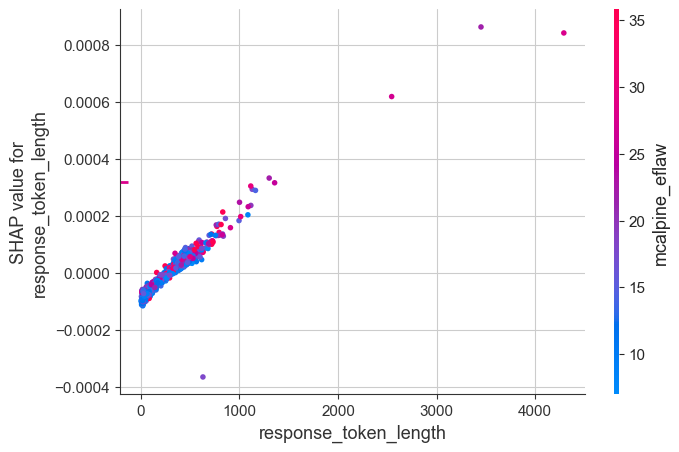

In [127]:
import numpy as np
import shap
import matplotlib.pyplot as plt

shap.initjs()

X_shap = X_train.sample(min(len(X_train), 1000), random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

# 1. Get global importance to pick a main feature
shap_abs_mean = np.abs(shap_values).mean(axis=0)
feature_names = np.array(X_shap.columns)
sorted_idx = np.argsort(-shap_abs_mean)  # descending
feature_names_sorted = feature_names[sorted_idx]

main_feature = feature_names_sorted[0]  # most important feature
print("Main feature for interactions:", main_feature)

# 2. Get top interaction partners for this main feature
interaction_ranking = shap.utils.approximate_interactions(
    main_feature,
    shap_values,
    X_shap
)
top_k = 10  # number of strongest interactions to inspect

for idx in interaction_ranking[:top_k]:
    other_feature = feature_names[idx]
    print(f"Interaction: {main_feature} × {other_feature}")

    shap.dependence_plot(
        main_feature,
        shap_values,
        X_shap,
        interaction_index=other_feature
    )
